In [1]:
import os
import os.path
import pickle
import sys

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

SCRIPT_PATH = os.path.join('..', 'scripts')
if SCRIPT_PATH not in sys.path:
    sys.path.append(SCRIPT_PATH)
from features import CATEGORICAL_FEATURES, VECTOR_FEATURES

In [2]:
NOTE = 'リッジ回帰特徴量ミニマム'
notebook_name = '049'

N = 5
CV = f'Stratified-Kfold(K={N})'

OUTPUT_DIR = os.path.basename(notebook_name)
SUB_FILENAME = notebook_name[:3] + '_submission.csv'
assert(SUB_FILENAME not in pd.read_csv('submissions.csv').filename.tolist())
print(SUB_FILENAME, OUTPUT_DIR)
if not os.path.isdir(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

SEED = 1

049_submission.csv 049


In [3]:
def get_estimator(*,
                  categorical_features=None,
                  discrete_features=None,
                  vector_features=None,
                  features=None) -> Pipeline:
    preprocessor = ColumnTransformer(
        transformers=[
            ('discrete', StandardScaler(), discrete_features),
            ('categorical', 'passthrough', categorical_features)
        ]
    )
    clf = RidgeClassifierCV(alphas=(0.1, 1.0, 10.0, 100.0),
                            class_weight='balanced')
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('estimator', clf)
         ]
    )

In [4]:
train = pd.read_csv(os.path.join('001_EDA', 'train_data_preprocessed.csv'))
test = pd.read_csv(os.path.join('001_EDA', 'test_data_preprocessed.csv'))

In [5]:
CATEGORICAL_FEATURES

['batterID',
 'pitcherID',
 'Match',
 'isBatterHandLeft',
 'isPitcherHandLeft',
 'isBatterPitcher',
 'isBottom',
 'batterTeam',
 'pitcherTeam',
 'b1',
 'b2',
 'b3']

In [6]:
# Minimal features
minimal_features = [
    'inningNo',
    'totalPitchingCount',
    'B',
    'S',
    'O',
    'b1',
    'b2',
    'b3',
    'numRunners',
    'batterID',
    'pitcherID',
    'Match',
    'isBatterHandLeft',
    'isPitcherHandLeft',
    'isBatterPitcher',
    'isBottom',
    'batterTeam',
    'pitcherTeam',
]

categorical_features = [f for f in minimal_features if f in CATEGORICAL_FEATURES]
discrete_features = list(set(minimal_features) - set(categorical_features))
print(categorical_features)
print(discrete_features)

# Execute if categories should be one-hot style
for c in categorical_features:
    assert(train[c].isin(test[c]).sum() == train.shape[0])
    assert(test[c].isin(train[c]).sum() == test.shape[0])

train = pd.get_dummies(train, columns=categorical_features, drop_first=True)
test = pd.get_dummies(test, columns=categorical_features, drop_first=True)

assert(set(train.columns.tolist()) - set(test.columns.tolist()) == {'y'})
assert(set(test.columns.tolist()) - set(train.columns.tolist()) == set())

categorical_features_1hot = []
for c in categorical_features:
    categorical_features_1hot += [c_ for c_ in train.columns if c_.startswith(f'{c}_')]
print(categorical_features_1hot)

features = discrete_features + categorical_features_1hot

['b1', 'b2', 'b3', 'batterID', 'pitcherID', 'Match', 'isBatterHandLeft', 'isPitcherHandLeft', 'isBatterPitcher', 'isBottom', 'batterTeam', 'pitcherTeam']
['O', 'B', 'numRunners', 'inningNo', 'totalPitchingCount', 'S']
['b1_1', 'b2_1', 'b3_1', 'batterID_0', 'batterID_2', 'batterID_5', 'batterID_9', 'batterID_11', 'batterID_12', 'batterID_15', 'batterID_18', 'batterID_19', 'batterID_21', 'batterID_22', 'batterID_26', 'batterID_27', 'batterID_28', 'batterID_29', 'batterID_31', 'batterID_34', 'batterID_36', 'batterID_37', 'batterID_39', 'batterID_42', 'batterID_45', 'batterID_47', 'batterID_50', 'batterID_55', 'batterID_56', 'batterID_58', 'batterID_60', 'batterID_67', 'batterID_70', 'batterID_72', 'batterID_73', 'batterID_75', 'batterID_80', 'batterID_82', 'batterID_84', 'batterID_85', 'batterID_87', 'batterID_89', 'batterID_91', 'batterID_98', 'batterID_102', 'batterID_103', 'batterID_105', 'batterID_106', 'batterID_111', 'batterID_112', 'batterID_114', 'batterID_117', 'batterID_118', 'b

In [7]:
# features = [c for c in train.columns if c not in ('id', 'y')]
# assert(set(features) - set(test.columns.tolist()) == set())

In [8]:
# discrete_features = [f for f in features if f not in categorical_features]
# discrete_features

In [9]:
%%time
splitter = StratifiedKFold(shuffle=True, random_state=SEED, n_splits=N)
cv_pred_dfs = []
pred_dfs = []
metrics = {'train': [], 'valid': []}
models = []
for i, (train_idx, valid_idx) in enumerate(splitter.split(train, train.y)):
    id_train, X_train, y_train, id_valid, X_valid, y_valid = (
        train.iloc[train_idx].id,
        train.iloc[train_idx][features],
        train.iloc[train_idx].y,
        train.iloc[valid_idx].id,
        train.iloc[valid_idx][features],
        train.iloc[valid_idx].y,
    )
    clf = get_estimator(features=features,
                        discrete_features=discrete_features,
                        categorical_features=categorical_features_1hot)
    clf.fit(X_train, y_train.values)
    models.append(clf)
    # Evaluate (trian set)
    pred_train = clf.predict(X_train)
    
    if pred_train.ndim > 1:
        pred_train = np.squeeze(pred_train)
    pred_train_df = pd.DataFrame(
        {
            'id': id_train,
            'actual': y_train,
            'prediction': pred_train,
        }
    )
    pred_train_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for train set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_train, pred_train))
    print()
    metrics['train'].append(f1_score(y_train, pred_train, average='macro'))
    # Evaluate (valid set)
    pred_valid = clf.predict(X_valid)
    if pred_valid.ndim > 1:
        pred_valid = np.squeeze(pred_valid)
    pred_valid_df = pd.DataFrame(
        {
            'id': id_valid,
            'actual': y_valid,
            'prediction': pred_valid,
        }
    )
    pred_valid_df['train'] = 0
    print('*' * 10 + f'Confusion matrix for validation set (Fold {i + 1})' + '*' * 10)
    print(confusion_matrix(y_valid, pred_valid))
    print()
    metrics['valid'].append(f1_score(y_valid, pred_valid, average='macro'))
    # Save cv result
    cv_pred_df = pd.concat([pred_train_df, pred_valid_df], axis=0)
    cv_pred_df['fold'] = i + 1
    cv_pred_dfs.append(cv_pred_df)
    # Inference
    try:
        infer = clf.predict_proba(test[features].copy())
    except AttributeError:
        infer = clf.decision_function(test[features].copy())
    pred_df = pd.DataFrame(
        data=infer,
        columns=clf[-1].classes_
    )
    pred_df['id'] = test.id.values
    pred_df['fold'] = i + 1
    pred_dfs.append(pred_df)



**********Confusion matrix for train set (Fold 1)**********
[[ 840 1108  334  392  488  686  376  842]
 [ 337 1389  170  242  297  478  262  571]
 [ 205  394  333  273  285  359  181  363]
 [ 157  266  116  368  233  215  120  234]
 [  41   69   23   38  192   75   26   76]
 [   2    3    0    2    2  127    7    7]
 [   0    0    0    0    0    0    8    0]
 [   1    0    0    1    1    0    1   92]]

**********Confusion matrix for validation set (Fold 1)**********
[[187 292  84 120 135 177  98 174]
 [ 98 301  48  71  77 135  70 136]
 [ 54  96  57  76  76  96  53  91]
 [ 35  62  49  58  59  74  31  59]
 [  8  23  20  12  12  25  16  19]
 [  4   3   1   3   8   7   4   7]
 [  1   0   1   0   0   0   0   1]
 [  2   5   2   3   3   1   2   6]]

**********Confusion matrix for train set (Fold 2)**********
[[ 933 1093  356  344  486  623  462  769]
 [ 374 1346  171  185  294  459  328  589]
 [ 216  381  386  209  305  321  223  352]
 [ 148  239  147  331  226  201  163  254]
 [  36   71   3

In [10]:
metrics = pd.DataFrame(metrics).describe()
metrics.to_csv(os.path.join(OUTPUT_DIR, 'metrics.csv'))
metrics

,train,valid
count,5.000000,5.000000
mean,0.189560,0.123818
std,0.001687,0.002984
min,0.187342,0.119426
25%,0.188926,0.122510
50%,0.189195,0.124384
75%,0.190548,0.125637
max,0.191786,0.127132


In [11]:
cv_results = pd.concat(cv_pred_dfs)
cv_results.to_csv(os.path.join(OUTPUT_DIR, 'cross_validation.csv'), index=False)
cv_results

,id,actual,prediction,train,fold
0,0,0,1,0,1
1,1,1,6,0,1
2,2,0,6,0,1
3,3,2,6,0,1
4,4,4,6,0,1
...,...,...,...,...,...
17126,9690,0,1,0,5
17129,9693,1,4,0,5
17130,16833,1,1,0,5
17133,9762,1,7,0,5


In [12]:
submission_ = pd.concat(pred_dfs)
submission_

,0,1,2,3,4,5,6,7,id,fold
0,-0.890634,-0.757102,-0.784002,-0.795474,-0.671201,-0.717770,-0.557515,-0.826302,27446,1
1,-0.758147,-0.729931,-0.615558,-0.682618,-0.750747,-0.945558,-0.588483,-0.928959,113,1
2,-0.654493,-0.564688,-0.681933,-0.744133,-0.854318,-1.028228,-0.600185,-0.872021,4479,1
3,-0.661243,-0.577427,-0.682279,-0.701772,-0.843943,-1.027602,-0.614353,-0.891380,29080,1
4,-0.718992,-0.759416,-0.679166,-0.738255,-0.795079,-0.797391,-0.629808,-0.881893,19319,1
...,...,...,...,...,...,...,...,...,...,...
33803,-0.639257,-0.519220,-0.764675,-0.761113,-0.800004,-0.828386,-0.895265,-0.792080,24272,5
33804,-0.791643,-0.840926,-0.631315,-0.637405,-0.651393,-0.673817,-0.933116,-0.840384,29106,5
33805,-0.855484,-0.855664,-0.582436,-0.551947,-0.689081,-0.754051,-1.015728,-0.695608,20679,5
33806,-0.532383,-0.715803,-0.562010,-0.563088,-0.601952,-0.933245,-1.028614,-1.062906,25901,5


In [13]:
submission_ = submission_.groupby('id')[[0, 1, 2, 3, 4, 5, 6, 7]].sum().sort_index().reset_index()
submission_

,id,0,1,2,3,4,5,6,7
0,0,-3.445348,-2.638314,-3.548471,-3.287374,-3.774864,-3.673023,-5.805620,-3.826986
1,1,-3.025845,-2.401538,-3.664887,-3.497587,-4.790512,-2.655853,-5.008831,-4.954948
2,2,-4.651726,-4.764217,-3.477169,-3.415240,-2.178902,-3.244728,-4.733951,-3.534067
3,3,-3.012229,-2.900839,-3.995508,-3.984016,-3.579465,-3.294827,-4.722891,-4.510225
4,4,-2.456127,-2.018737,-3.678409,-3.282497,-3.285493,-5.880483,-5.121902,-4.276350
...,...,...,...,...,...,...,...,...,...
33803,33803,-2.627749,-3.364758,-3.284295,-3.194979,-3.250856,-4.797346,-5.037199,-4.442818
33804,33804,-2.923373,-2.848559,-3.720768,-3.306814,-3.818718,-4.463907,-5.143059,-3.774803
33805,33805,-3.581497,-3.463761,-4.402638,-4.143832,-4.287387,-3.814490,-4.134618,-2.171778
33806,33806,-4.568052,-4.050412,-3.901826,-3.804910,-3.432838,-2.141026,-4.125388,-3.975548


In [14]:
submission = pd.DataFrame(
    {
        'id': submission_.id,
        'y' : np.argmax(submission_[[0, 1, 2, 3, 4, 5, 6, 7]].values, axis=1)
    }
)
submission

,id,y
0,0,1
1,1,1
2,2,4
3,3,1
4,4,1
...,...,...
33803,33803,0
33804,33804,1
33805,33805,7
33806,33806,5


0    0.369573
1    0.273226
2    0.174603
3    0.124650
4    0.039391
5    0.010913
6    0.000642
7    0.007003
Name: y, dtype: float64

0    0.143635
1    0.333945
2    0.051822
3    0.090896
4    0.089505
5    0.115978
6    0.052946
7    0.121273
Name: y, dtype: float64

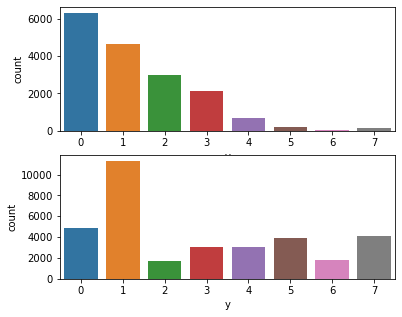

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(6., 5.))
fig.add_subplot(2, 1, 1)
sns.countplot(data=train, x='y')
fig.add_subplot(2, 1, 2)
sns.countplot(data=submission, x='y')
display(train.y.value_counts(normalize=True).sort_index())
display(submission.y.value_counts(normalize=True).sort_index())

In [16]:
submission.to_csv(os.path.join(OUTPUT_DIR, SUB_FILENAME), index=False)

In [17]:
metrics.loc['mean', 'train'], metrics.loc['mean', 'valid']

(0.1895596262647714, 0.1238176565402346)

In [18]:
print('"{}","{}","{:.6f}","{:.6f}","","{}"'.format(SUB_FILENAME, CV, metrics.loc['mean', 'train'], metrics.loc['mean', 'valid'], NOTE))

"049_submission.csv","Stratified-Kfold(K=5)","0.189560","0.123818","","リッジ回帰特徴量ミニマム"


In [19]:
%%time
for i, model in enumerate(models):
    with open(os.path.join(OUTPUT_DIR, f'model_fold{i + 1}.pickle'), 'wb') as f:
        pickle.dump(model, f)
        f.close()

Wall time: 9 ms


In [20]:
%%time
imp_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'feature_importances_'):
            feature_importance = final_estimator.feature_importances_
        else:
            feature_importance = final_estimator.final_estimator.get_feature_importance()
            
        if hasattr(final_estimator, 'feature_name_'):
            feature_names = final_estimator.feature_name_
        elif hasattr(final_estimator, 'feature_names_'):
            feature_names = final_estimator.feature_names_
        else:
            feature_names = final_estimator.get_booster().feature_names
        imp_df_ = pd.DataFrame(
            {
                'feature': feature_names,
                'importance': feature_importance
            }
        )
        imp_df_['fold'] = i + 1
        imp_df = pd.concat([imp_df, imp_df_])
    except AttributeError:
        pass

if imp_df.shape[0] > 0:
    imp_df.to_csv(os.path.join(OUTPUT_DIR, 'feature_importances.csv'), index=False)

Wall time: 1.04 ms


In [21]:
imp_df

""


In [22]:
%%time
coef_df = pd.DataFrame()
for i, model in enumerate(models):
    final_estimator = model[-1]
    try:
        if hasattr(final_estimator, 'coef_'):
            coefficient = final_estimator.coef_
            coef_df_ = pd.DataFrame(coefficient, columns=features)
            coef_df_['fold'] = i + 1
            coef_df_['y'] = final_estimator.classes_
            coef_df = pd.concat([coef_df, coef_df_])
    except AttributeError:
        pass

if coef_df.shape[0] > 0:
    coef_df.to_csv(os.path.join(OUTPUT_DIR, 'coefficients.csv'), index=False)

Wall time: 137 ms


In [23]:
coef_df

,O,B,numRunners,inningNo,totalPitchingCount,S,b1_1,b2_1,b3_1,batterID_0,...,pitcherTeam_5,pitcherTeam_6,pitcherTeam_7,pitcherTeam_8,pitcherTeam_9,pitcherTeam_10,pitcherTeam_11,pitcherTeam_12,fold,y
0,0.029760,-0.110404,-0.003418,0.006591,0.009684,-0.004552,-0.027805,0.023437,0.001664,0.007957,...,-0.009152,0.000512,0.004223,0.040652,-0.012607,-0.026349,0.025787,0.021637,1,0
1,0.013570,-0.018372,-0.016551,0.005135,0.000914,-0.123946,-0.021271,0.016625,-0.008441,0.013108,...,-0.006847,-0.004362,-0.030406,0.058958,0.005473,-0.007158,0.042022,0.015214,1,1
2,-0.003174,-0.011104,0.000062,0.001591,-0.003874,0.066363,0.021482,-0.006804,-0.014630,0.030059,...,0.014311,0.024640,-0.004773,0.032783,-0.032550,0.015737,-0.009743,0.002445,1,2
3,-0.019036,-0.046495,0.010619,0.002454,0.082547,0.011415,0.025116,0.001854,-0.018573,-0.007495,...,-0.011362,0.020862,-0.055617,0.062734,-0.021091,-0.019088,0.065278,0.011660,1,3
4,0.011506,-0.001948,-0.013404,0.023343,0.016064,0.056445,0.002457,0.004492,-0.017548,0.034454,...,0.028308,-0.009227,-0.026843,0.029815,0.021866,-0.005842,0.002497,-0.042456,1,4
5,-0.024735,0.098516,-0.006070,0.001734,-0.074696,0.052560,-0.010814,-0.024582,0.030597,-0.034572,...,-0.020417,-0.097085,0.120294,-0.047511,-0.041747,0.011959,0.010877,0.034613,1,5
6,0.022449,0.057035,-0.001836,0.000761,-0.053446,0.010461,-0.031000,0.014315,0.015234,-0.008729,...,0.069139,0.076443,-0.095631,-0.066081,0.012025,0.039246,-0.026374,-0.010572,1,6
7,-0.030341,0.032772,0.030599,-0.041609,0.022808,-0.068747,0.041835,-0.029337,0.011695,-0.034783,...,-0.063980,-0.011782,0.088752,-0.111350,0.068631,-0.008505,-0.110344,-0.032542,1,7
0,0.030176,-0.105850,-0.008323,0.002954,0.007518,-0.006407,-0.020169,0.016026,-0.002475,0.015738,...,-0.019860,0.018924,0.010851,0.011602,-0.002488,-0.010079,0.055042,0.011378,2,0
1,0.014144,-0.024793,-0.022919,0.007454,0.009035,-0.126606,-0.005152,-0.009898,-0.003176,0.003233,...,-0.012196,0.004901,-0.013094,0.014056,0.019453,0.008255,0.047075,0.026431,2,1
